In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.cm as cm
import cv2
import svmpy
import cvxopt
from cvxopt import solvers
import itertools
import time
import os

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'NSimSun,Times New Roman'

# 一、设置可以调整的参数

In [21]:
nonroad = 50
road = 50
choice = np.array([1,2])
dimension = choice.size
pic_index = 1
pic_name = r'data\picData\%d.png'%pic_index


## 1、读取图像

In [22]:
RGB = cv2.imread(pic_name)
img = RGB.copy()
# 获取图片维度大小
m = RGB.shape[0]
n = RGB.shape[1]


## 2、鼠标输入并绘制图形

In [23]:
global indexNR, indexR, last, lastxx, lastyy
indexNR = nonroad
indexR = road
last = 2
lastxx = 0
lastyy = 0
trnx = np.zeros([indexNR+indexR, dimension])
trny = np.zeros([indexNR+indexR, 1])


In [24]:
def on_Mouse(event, x, y, flags, param):
    global indexNR, indexR, last, lastxx, lastyy
    if indexNR == 0 and indexR == 0:
        cv2.setWindowTitle("image", 'Selection Ends')
        cv2.destroyAllWindows()
        return
    cv2.setWindowTitle("image", 'Please choose %d nonroad points, %d road points'%(indexNR,indexR))
    # x,y为点击的坐标87
    trnx[indexNR+indexR-1,:] = img[y,x,choice]
    if event == cv2.EVENT_LBUTTONDOWN and indexNR > 0:
        trny[indexNR+indexR-1,0] = -1
        cv2.drawMarker(img,(x, y), (255,0,0), cv2.MARKER_STAR, markerSize=10)
        last = 1
        lastxx = x
        lastyy = y
        indexNR = indexNR - 1
    elif event == cv2.EVENT_RBUTTONDOWN and indexR > 0:
        trny[indexNR+indexR-1,0] = 1
        cv2.drawMarker(img,(x, y), (0,0,0), cv2.MARKER_CROSS, markerSize=10)
        last = 3
        lastxx = x
        lastyy = y
        indexR = indexR - 1
    elif event == cv2.EVENT_MBUTTONDOWN and last != 2:
        if last == 1:
            indexNR = indexNR + 1
        else:
            indexR = indexR + 1
        cv2.drawMarker(RGB,(lastxx, lastyy), (0,0,255), cv2.MARKER_TILTED_CROSS, markerSize=10,thickness=3)
        last = 2
    cv2.imshow("image", img)
        

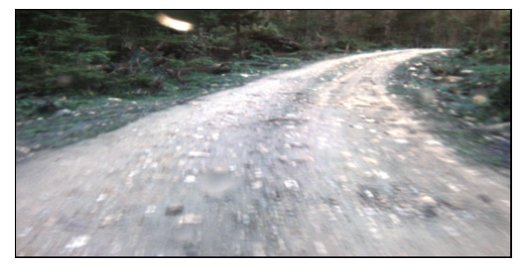

In [25]:
cv2.namedWindow("image")
cv2.setWindowTitle("image", 'Please choose %d nonroad points, %d road points'%(nonroad,road))
cv2.setMouseCallback("image", on_Mouse)
cv2.imshow("image", img)
key = cv2.waitKey(0)
if key == ord('q'):
    cv2.destroyAllWindows()

plt.xticks([])  #去掉横坐标值
plt.yticks([])  #去掉纵坐标值
plt.imshow(img)
plt.show()

## 3、归一化处理 

In [7]:
zs = svmpy.Zscore(trnx)
trnx_ = zs.zscore_sample(trnx)
RGB_ = zs.zscore_sample(RGB[:,:,choice])

# 二、结果显示

In [8]:
def plot_result(pic, model):
    reslm = np.zeros(RGB.shape)
    # 获取图片维度大小
    m = RGB.shape[0]
    n = RGB.shape[1]
    for i in range(m):
        for j in range(n):
            testx = pic[i,j,:].astype(np.double)
            testx = testx.reshape((1,dimension))
            preY = model.predict(testx)
            if preY > 0:
                reslm[i,j,:] = np.array([1.,1.,1.])
            else:
                reslm[i,j,:] = np.array([0,0,0])
    
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.title("%s" % (model.name), fontsize=16)
    plt.imshow(reslm)
    plt.show()

# 三、通过SVM进行求解

## 1.在原空间进行求解 

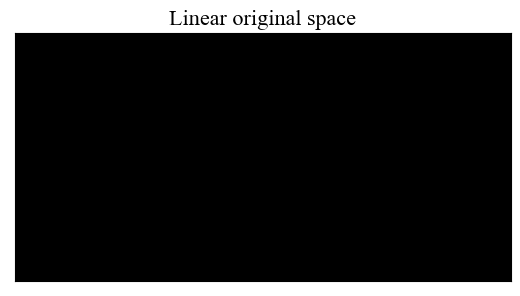

In [9]:
svm1 = svmpy.SVM_original_space()
svm1.train(trnx, trny)
plot_result(RGB[:,:,choice], svm1)

## 2.在对偶空间进行求解 

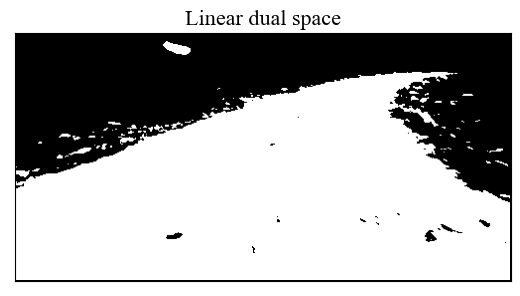

In [10]:
svm2 = svmpy.SVM_dual_space()
svm2.train(trnx, trny)
plot_result(RGB[:,:,choice], svm2)

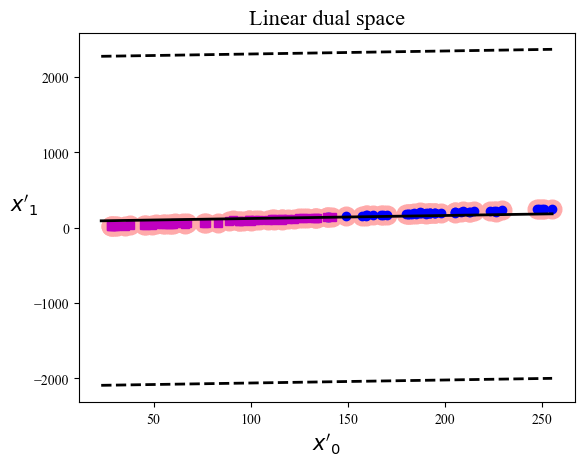

In [11]:
svmpy.draw.plot_svc_decision_boundary(svm2, trnx, trny)
plt.show()

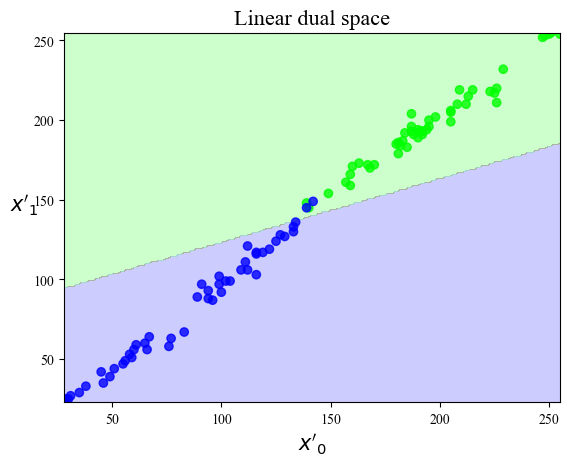

In [12]:
svmpy.draw.plot_svc_decision_boundary2(svm2, trnx, trny)
plt.show()

## 3.软间隔线性SVM

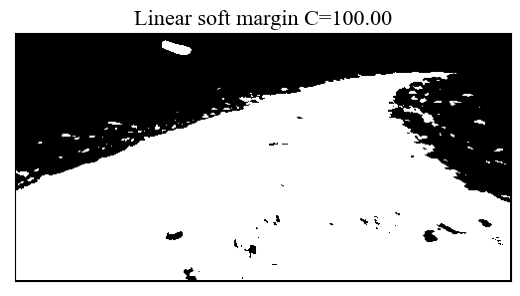

In [13]:
svm3 = svmpy.SVM_soft_margin(C=100)
svm3.train(trnx_, trny)
plot_result(RGB_, svm3)

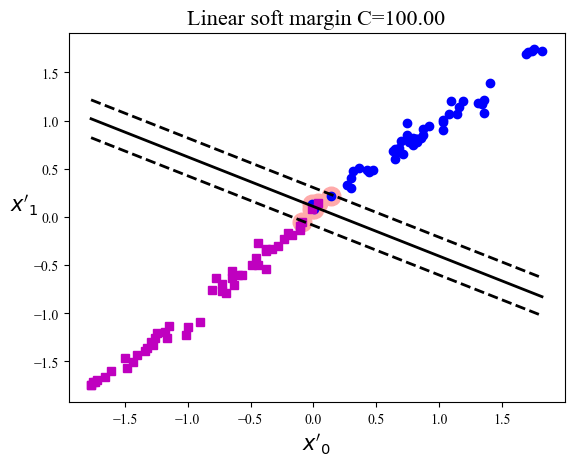

In [14]:
svmpy.draw.plot_svc_decision_boundary(svm3, trnx_, trny)
plt.show()

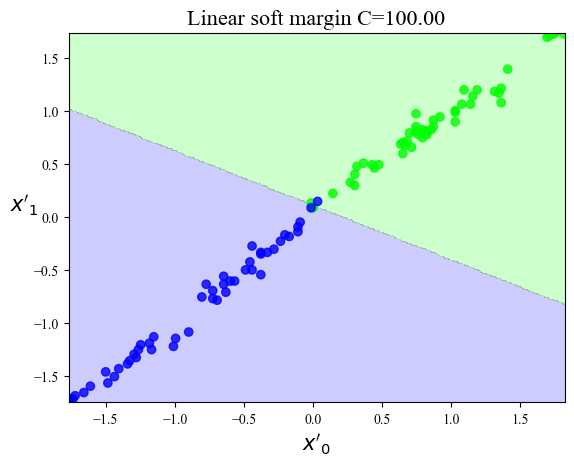

In [15]:
svmpy.draw.plot_svc_decision_boundary2(svm3, trnx_, trny)
plt.show()

## 4.非线性SVM

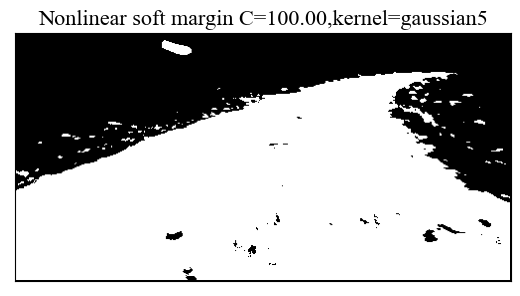

In [16]:
sigma = 5
svm4 = svmpy.SVM(C=100, kernel = svmpy.Kernel.gaussian(sigma), kernelname="gaussian%d"%sigma)
svm4.train(trnx_, trny)
plot_result(RGB_, svm4)

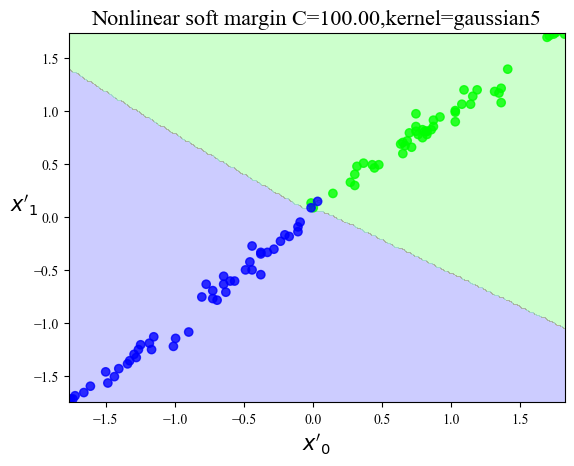

In [17]:
svmpy.plot_svc_decision_boundary2(svm4, trnx_, trny)
plt.show()

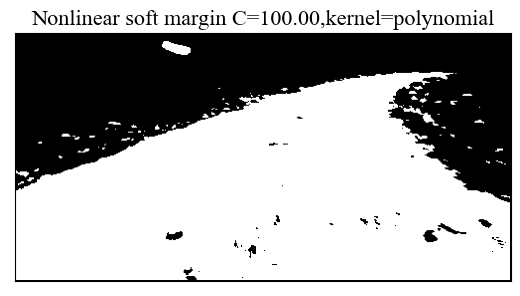

In [18]:
svm5 = svmpy.SVM(C=100, kernel = svmpy.Kernel._polykernel(3,1), kernelname="polynomial")
svm5.train(trnx_, trny)
plot_result(RGB_, svm5)

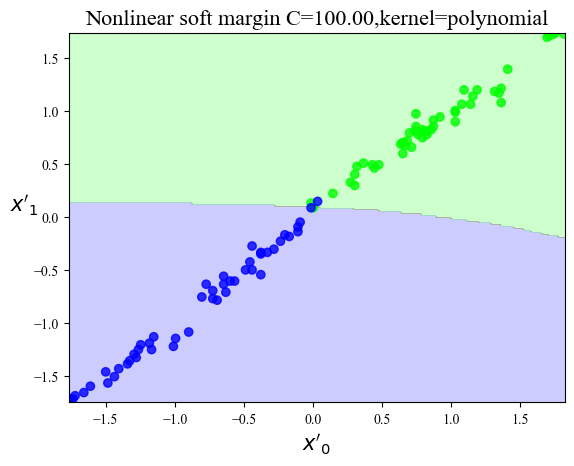

In [19]:
svmpy.plot_svc_decision_boundary2(svm5, trnx_, trny)
plt.show()